In [ ]:


%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
# 설정값을 이렇게 설정도 한다

plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
# 캐글에서 많이 사용하는 라이브러리
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')




In [ ]:

beluga = pd.DataFrame({'since_start_hour': [8.0, 8.0, 20.0, 28.0, 37.0, 45.0, 85.0, 85.0, 100.0, 134.0, 134.0, 143.0, 148.0],
                       'Score': [ 0.400,  0.398,  0.393,  0.390,  0.383,  0.380,  0.379,  0.377,  0.376,  0.376,  0.375,  0.371,  0.368]})
others = pd.DataFrame({'since_start_hour': [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,68,69,70,71,72,73,74,75,76,77,78,79,80,81,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148],
                        'BestScore': [.452,.452,.452,.452,.452,.452,.421,.421,.421,.406,.398,.398,.398,.398,.394,.394,.394,.394,.391,.391,.390,.390,.390,.390,.389,.389,.389,.389,.389,.389,.389,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.383,.383,.383,.383,.383,.383,.383,.383,.383,.383,.383,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.373,.373,.373]})

#
with plt.xkcd():
    # This figure will be in XKCD-style ?
    fig, ax = plt.subplots()
    # alpha : 투명도

    ax.plot(others.since_start_hour.values, others.BestScore.values, 'b', alpha=0.8, lw=5, label='others')
    ax.plot(beluga.since_start_hour.values, beluga.Score.values, 'k', alpha=0.8, lw=5, label='beluga')
    ax.set_ylim(0.36, 0.4)
    ax.legend(loc=0)
    ax.set_xlabel('hours since start')
    ax.set_ylabel('RMSLE')
    ax.set_title('Race for the top')

    ax.tick_params(direction='out' , length=6,width=2,colors='r')

    plt.show()

In [ ]:
### Data understanding



In [ ]:
np.random.seed(1989)
N = 100000  # number of sample rows in plots
t0 = dt.datetime.now()


train = pd.read_csv('C:\\Users\\tjdal\\PycharmProjects\\Kaggle\\newyorkcitytaxi\\train\\train.csv')
test = pd.read_csv('C:\\Users\\tjdal\\PycharmProjects\\Kaggle\\newyorkcitytaxi\\test\\test.csv')

In [13]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [14]:

train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


In [ ]:
sample_submission = pd.read_csv('C:\\Users\\tjdal\\PycharmProjects\\Kaggle\\newyorkcitytaxi\\sample_submission\\sample_submission.csv')


In [ ]:
print('we have {} train set'.format(len(train.shape[0])))
print('we have {} test set'.format(len(test.shape[0])))

In [20]:
# nunique 유니크 개수
#
print('unique id : ' , train.id.nunique())

unique id :  1458644


In [23]:
import numpy as np

# intersect1d args1에 있지만 arg2에 없는 것
len(np.intersect1d(train.id.values, test.id.values))

array([], dtype=object)

In [27]:
# | 합집합이고 문자열로 뺐을 때 n만 y만 있다면 이상치 없다는 것 이런 행위를 왜 하는 지는
# 현업에서 겪어보면 축적되는 경험이다 생각해보니
print('The store_and_fwd_flag has only two values {}.'.format(str(set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique()))))

The store_and_fwd_flag has only two values {'N', 'Y'}.


In [25]:
test.dtypes


id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
dtype: object

In [26]:
train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [29]:
# type change

AttributeError: Can only use .dt accessor with datetimelike values

In [42]:
train['pickup_datetime'] =pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] =pd.to_datetime(test.pickup_datetime)



train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date

train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

In [ ]:
# Y is 1 N is 0 trick


train['store_and_fwd_flag']= 1 * (train.store_and_fwd_flag == 'Y')
test['store_and_fwd_flag']= 1 * (train.store_and_fwd_flag == 'Y')

In [40]:
# real y check
# csv헤더컬럼이 1번 차지하고 인덱스는 0부터 시작하니 데이터프레임에서는 row -2가 될수있다.
train.iloc[348,:]

id                              id1633648
vendor_id                               1
pickup_datetime       2016-06-20 14:19:16
dropoff_datetime      2016-06-20 14:34:34
passenger_count                         1
pickup_longitude               -73.977905
pickup_latitude                 40.754871
dropoff_longitude              -73.952774
dropoff_latitude                40.768166
store_and_fwd_flag                      0
trip_duration                         918
pickup_date                    2016-06-20
Name: 348, dtype: object

In [43]:
# pickup_datetime type is datetime so on x(datetime).total_seconds method 사용 가능

# map은 series에 apply는 dataframe

train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
# preprocess는 왜 ? -> 모델에 넣기 좋게 피쳐 가공 필요 (사전에 모델 설계 필요하다는 뜻)


In [44]:
# 기존에 주어진 값과 비교 의심
# 시각화해서 탐색한다 의심점을 추상적 객체를 시각화해서

duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
#%
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

In [ ]:


train['trip_duration'].max() // 3600

In [ ]:
##We can see that the max trip_duration is ~ 1000 hours.
# Fortunately the evaluation metric is RMSLE and not RMSE
# . Outliers will cause less trouble.
# We could logtransform our target label and use RMSE during training.
# ROOT 를 사용하기 때문에 아웃라이어의 trouble이 적어진다는 뜻

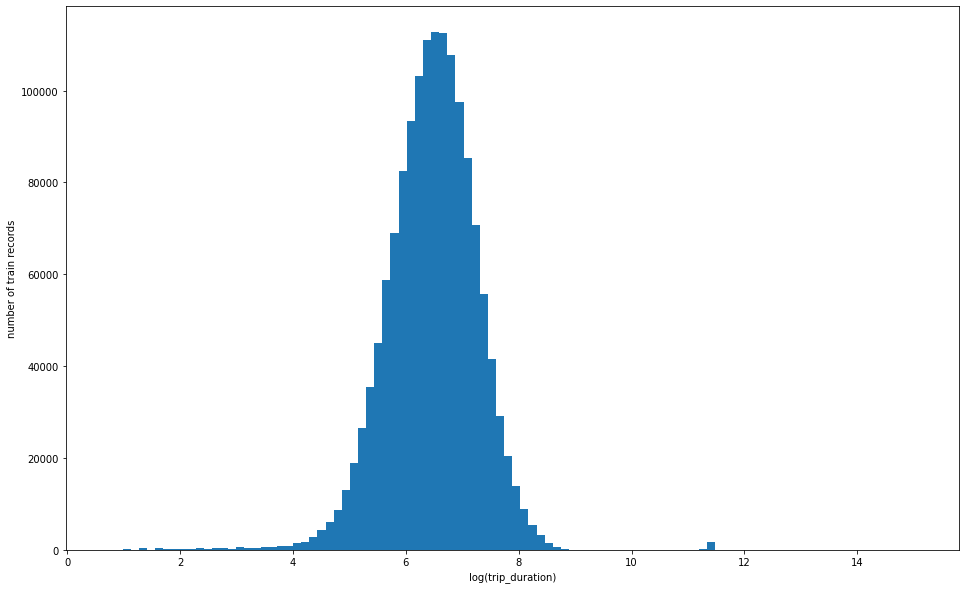

In [45]:
# 분포가 이쁘지 않고 outlier가 주는 영향이 너무 크기 때문에? log를 취해서 outlier 영향 줄이도록 이건 아니고 이미 평가지표가 rmse이기떄문
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
# plt.hist(train['trip_dupration'].values, bin =100) # 그래프가 보기 좋지 않음
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()


In [50]:
# 데이터프레임 boolean mask 씌윅
#mask = train.groupby('pickup_date').count() < 4000
#mask


In [ ]:
train.dtypes()

In [61]:
train[train['pickup_date'] =='2016-01-01']

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,check_trip_duration,log_trip_duration


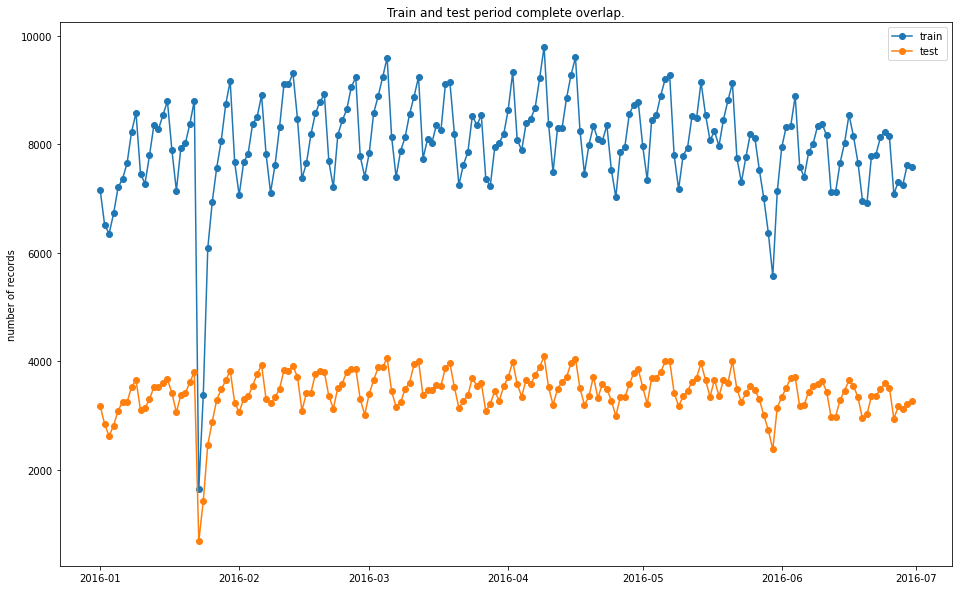

In [70]:

plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

In [ ]:
# 특정 값 찾아보기
df = train.groupby('pickup_date').count()
# iloc 에 true false mask 는 넘겨 주지말고
# df.iloc[(df['id']<2000) ]
df.loc[(df['id']<2000) ]